### Example code for computing CIV distance.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import richardsplot as rplot
from sklearn.preprocessing import scale

from CIVfunctions import project, CIV_distance

---

#### Basic implementation

Load in example file with CIV EW+Blueshift already computed.

In [8]:
dat = pd.read_csv("data/SpringFinalFigs_moreParams.csv")
dat.iloc[:,12:].head()

,SDSS_NAME_1,RA_1,DEC_1,REDSHIFT,PLATE,FIBER,MJD,TARGET_FLAG_TARGET_1,NSPECOBS_1,UNIFORM_TARGET_1,...,ICA_CIV_EQW,ICA_CIV_EQW_new2021,RM_DIST_UNSCALE,RM_DIST_SCALE,CIV_BLUESHIFT_SCALED,CIV_EQW_SCALED,CIVBestfit_Index,L3GHz [W/Hz],CIV_DIST_021721,CIV_DIST_041921
0,001342.45-002412.6,3.426880,-0.403514,1.6409,389,274,51795,68,1,0,...,101.160257,35.900650,1728.413701,3.486256,0.722760,-0.879689,275801.0,24.469498,3.506315,2.792875
1,014023.83+141151.7,25.099302,14.197709,1.6544,426,514,51882,4,1,0,...,95.079534,33.912371,414.691980,2.589969,-0.319656,-0.943523,238121.0,24.841584,2.618358,2.230519
2,014658.21-091505.2,26.742563,-9.251470,1.6516,664,543,52174,1048580,1,0,...,97.289514,34.648832,646.782974,2.704445,-0.134167,-0.920323,244881.0,23.606351,2.734290,2.304035
3,015720.27-093809.1,29.334463,-9.635872,1.6494,666,298,52149,4,1,0,...,122.740901,43.720855,796.239578,2.635625,-0.014596,-0.653142,240918.0,23.761645,2.685961,2.164442
4,081656.84+492438.1,124.236839,49.410603,1.6464,440,552,51885,1048580,2,0,...,102.881571,36.524054,1490.190560,3.289717,0.534205,-0.861619,269740.0,23.545828,3.312861,2.652129


In [10]:
dat.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1',
       ...
       'ICA_CIV_EQW', 'ICA_CIV_EQW_new2021', 'RM_DIST_UNSCALE',
       'RM_DIST_SCALE', 'CIV_BLUESHIFT_SCALED', 'CIV_EQW_SCALED',
       'CIVBestfit_Index', 'L3GHz [W/Hz]', 'CIV_DIST_021721',
       'CIV_DIST_041921'],
      dtype='object', length=363)

In [11]:
ew   = dat[["ICA_CIV_EQW_new2021"]].values.flatten()
blue = dat[["ICA_CIV_BLUESHIFT"]].values.flatten()

#Best-fit line -- this part could be improved
bestfit = np.load("data/RM_CIV_bestFitLine_noScale.npy")[65000:,:]

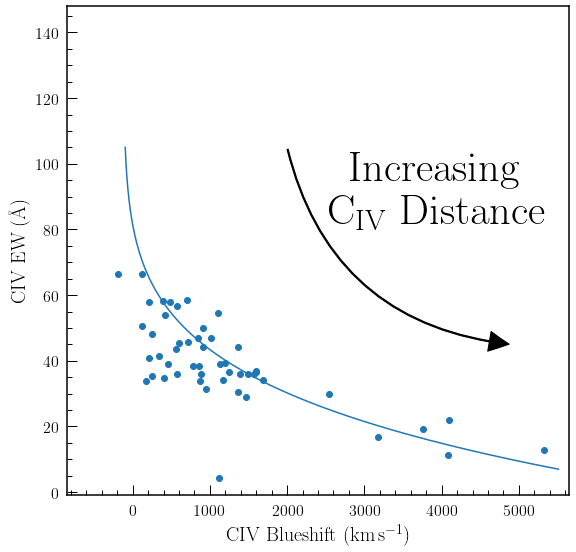

In [12]:
fig = plt.figure(figsize=(9,9))

#Visualize increasing CIV distance
style = "Simple, tail_width=1.25, head_width=20, head_length=20"
kw = dict(arrowstyle=style, color="k")
a1 = patches.FancyArrowPatch((2000, 105), (4900, 45),
                             connectionstyle="arc3,rad=.35", **kw)
plt.gca().add_patch(a1)
plt.text(x=2800,y=95,s="Increasing", fontsize=42.5, weight='extra bold')
plt.text(x=2535,y=82,s="C$_\mathrm{IV}$ Distance", fontsize=42.5)

plt.plot(bestfit[:,0], bestfit[:,1])
plt.scatter(blue, ew)
plt.xlabel("CIV Blueshift (km\,s$^{-1}$)", fontsize=20)
plt.ylabel("CIV EW (Å)", fontsize=20)
plt.xlim(-850,5650)
plt.ylim(-1,148)

plt.show()

Note: points with EW $\gtrsim105$ Angstroms will be projected onto the top of the curve.

In [ ]:
# %load CIVfunctions
import numpy as np
from sklearn.preprocessing import scale

def project(data, fit):
    #Use: Project scattered data (data) onto a line of best fit (fit)
    #Returns: 2-D array of (x,y) locations on the line of your orthogonal projection
    
    #data: 2-D (N by 2) array of your data in some x-y space
    #fit: 2-D (N by 2) array of coordinates along your line of best fit
    
    locs = [] #this will contain xy locations along the best-fit curve corresponding to each data point's orthogonal projection onto said curve - python list faster than numpy array
    
    #Loop through each data point and compare with locations along fit
    for scat in data: 
        r2 = (scat[0]-fit[:,0])**2 + (scat[1]-fit[:,1])**2      #dist^2 of scat from each point along fit
        delta = [fit[np.argmin(r2), 0], fit[np.argmin(r2), 1]]  #save point along fit where dist^2 was minimum
        locs.append(delta)  
        
    return np.array(locs)


def CIV_distance(data_original, fit_original, step=1):
    #fit: N-by-2 array containing coordinates of points along best fit line 
    #data: N-by-2 [[x,y]] array of data 
    #NOTE: This really just caters to this situation (assumes monotonically decreasing fit_original)
    
    #1) Scale all the data equally
    xscale = scale(np.concatenate((fit_original[:,0], data_original[:,0]))) #add ``good`` mask to lofar to remove "bad" reconstructions
    yscale = scale(np.concatenate((fit_original[:,1], data_original[:,1])))
    fit = np.array([xscale[0:len(fit_original)], yscale[0:len(fit_original)]]).T
    data = np.array([xscale[len(fit_original):len(fit_original)+len(data_original)], yscale[len(fit_original):len(fit_original)+len(data_original)]]).T
    
    #2) data is now each point's orthogonal projection onto fit
    data = project(data, fit) 
        
    darr = [] #list to fill with distances along best-fit line for each point

    #3) Loop through each data point- start at tip of line and sum dist traveled until passing data point
    for scat in data:
        d = 0 #start at beginning of the line
        for i in range(0, fit.shape[0]-step, step):
            xp, x = fit[i,0], fit[i+step,0]
            yp, y = fit[i,1], fit[i+step,1] 
            dp = d
            d += np.sqrt((x-xp)**2 + (y-yp)**2)
            if yp >= scat[1] > y: #if we pass the projected y-coord, save the distance traveled
                darr.append((d+dp)/2) #save the average between dprevious and d
                break
                
    return np.array(darr)


In [14]:
from time import time

start = time()
data = np.array([blue, ew]).T
proj = project(data, bestfit)
dist = CIV_distance(data, bestfit) #compute CIV distances like this
end = time()

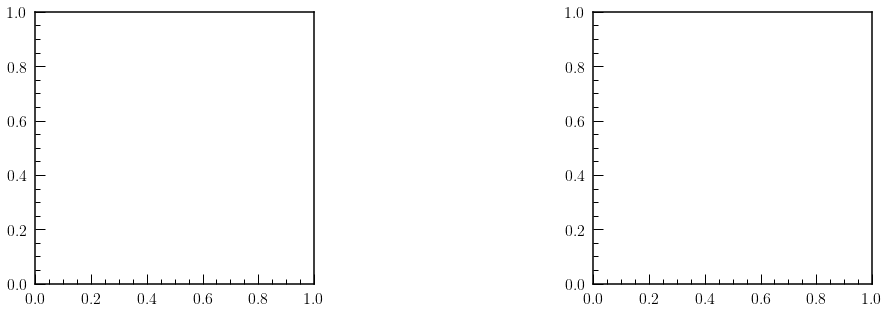

In [22]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(15,5))
plt.subplots_adjust(wspace=1.0)



---

#### Save time with the ``step`` parameter

``CIV_distance()`` function has an optional "step" parameter.  How it's normally set up is to project each data point onto the best-fit curve, then travel along the best-fit line--point-by-point--checking when you've passed a point on the line.  The default argument ``step=1`` will check every point along the curve, ``step=100`` will check every hundredth point etc.  Since the curve is so dense, you can often get away with a much higher step size than 1, increasing your runtime dramatically; for example, ``step=100`` will result in 100 times less iterations of the for loop inside ``CIV_distance()``.

Visualize accuracy as a fraction of step size.  Will consider "correct" to be the distances corresponding to ``step=1``.

In [44]:
from functools import reduce

#Get all factors of input number- use this function to find valid step sizes
def factors(n):    
    return set(reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))

In [70]:
step_list = np.sort(list(factors(98000)))[0:-15:2]
diff_list = [0]
dt_list   = [end - start]

In [71]:
step_list

array([   1,    4,    7,   10,   16,   25,   35,   49,   56,   80,  100,
        125,  175,  200,  250,  350,  400,  500,  700,  875, 1000, 1400,
       1960])

In [72]:
for step_size in step_list[1:]:
    start_time = time()
    idist = CIV_distance(data, bestfit, step=step_size)
    diff_list.append(np.median(np.abs((dist-idist)/dist)))
    end_time = time()
    
    dt_list.append(end_time - start_time)

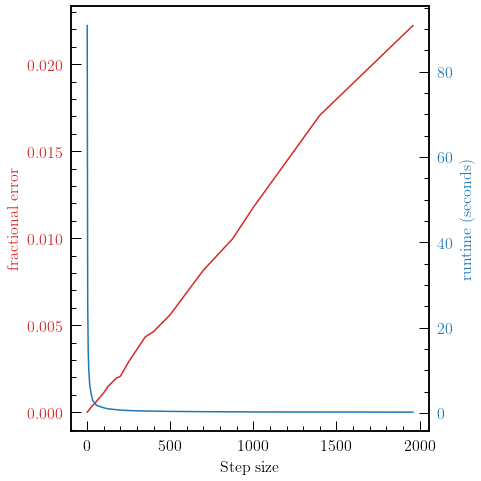

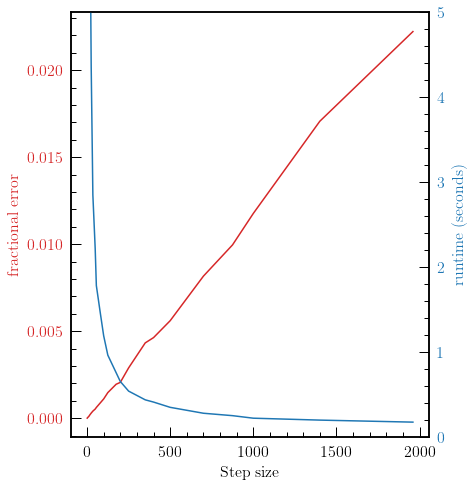

In [80]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Step size')
ax1.set_ylabel('fractional error', color=color)
ax1.plot(step_list, diff_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('runtime (seconds)', color=color)  # we already handled the x-label with ax1
ax2.plot(step_list, dt_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

fig, ax11 = plt.subplots()

color = 'tab:red'
ax11.set_xlabel('Step size')
ax11.set_ylabel('fractional error', color=color)
ax11.plot(step_list, diff_list, color=color)
ax11.tick_params(axis='y', labelcolor=color)

ax22 = ax11.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax22.set_ylabel('runtime (seconds)', color=color)  # we already handled the x-label with ax1
ax22.plot(step_list, dt_list, color=color)
ax22.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax22.set_ylim(0,5)
plt.show()

Plot showing both the time saved and median error in C IV distance as a function of step size.  Lesson learned: use a non-unity step size for lots of data! Roughly ``step=200`` looks like a good choice.  **Use the step paramter.**